In [1]:
import scanpy as sc
import pandas as pd
import re

In [2]:
gene_gtf_path = "/maps/projects/ralab/data/genome/hg38/gencode.v43.chr_patch_hapl_scaff.annotation.gtf"
abc_genes_path = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/software/scE2G_pipeline/241203/scE2G/ENCODE_rE2G/ABC/reference/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed" 
rna_matrix_path =  "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/K562_Xu/1.prepare_data/1.seurat_pipeline.240507/rna_count_matrix.t.csv.gz"
output_path = "adata.250317.h5ad"

In [3]:
adata = sc.read_csv(rna_matrix_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 7821 × 62757

In [5]:
def extract_attribute(gtf_attributes, att_of_interest):
    """
    Extracts the corresponding attribute value from the GTF attributes string.
    """
    # Split the string by space 
    parts = gtf_attributes.split(" ")
    if att_of_interest in parts:
        idx = parts.index(att_of_interest)
        if idx + 1 < len(parts):
            # Remove quotes and semicolons
            return parts[idx + 1].replace("\"", "").replace(";", "")
    return None


In [6]:
def map_gene_names(adata, gene_gtf_path, abc_genes_path):
    """
      1. Reads the gene GTF file and keeps only records where type equals 'gene'. 
         It extracts 'gene_name' and 'gene_id' using extract_attribute(). For gene_id, 
         a trailing decimal part is removed (e.g., "ENSG00000186092.5" is converted to "ENSG00000186092").
      2. Reads the abc_genes file (assumed to have no header, with columns ordered as:
         chr, start, end, name, score, strand, Ensembl_ID, gene_type), selects the 'name' and 'Ensembl_ID'
         columns, and renames 'name' to 'abc_name'.
      3. Merges the two dataframes on 'Ensembl_ID' (left join) and constructs a mapping with keys as gene_ref_name and values as abc_name.
      4. Filters the AnnData's gene list (adata.var_names) to only include genes present in the mapping,
         and updates their names accordingly.
    """
    # Read the gene GTF file (skipping comment lines) and assign column names
    gtf_cols = ["chr", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
    gene_ref = pd.read_csv(
        gene_gtf_path,
        sep="\t",
        header=None,
        comment='#',  # Skip comment lines
        names=gtf_cols
    )
    
    # Keep only records where 'type' is 'gene'
    gene_ref = gene_ref[gene_ref["type"] == "gene"].copy()
    
    # Extract gene_name and gene_id (for gene_id, remove trailing decimal digits, e.g., "ENSG00000186092.5" -> "ENSG00000186092")
    gene_ref["gene_ref_name"] = gene_ref["attributes"].apply(lambda x: extract_attribute(x, "gene_name"))
    gene_ref["Ensembl_ID"] = gene_ref["attributes"].apply(lambda x: extract_attribute(x, "gene_id"))
    gene_ref["Ensembl_ID"] = gene_ref["Ensembl_ID"].apply(lambda x: re.sub(r'\.\d+$', '', x) if pd.notnull(x) else x)
    
    # Drop duplicates and keep only the 'gene_ref_name' and 'Ensembl_ID' columns
    gene_ref = gene_ref[["gene_ref_name", "Ensembl_ID"]].drop_duplicates()
    
    # Read the abc_genes file (assuming no header) and assign column names
    abc_cols = ["chr", "start", "end", "name", "score", "strand", "Ensembl_ID", "gene_type"]
    abc_genes = pd.read_csv(abc_genes_path, sep="\t", header=None, names=abc_cols)
    # Select only the 'name' and 'Ensembl_ID' columns and rename 'name' to 'abc_name'
    abc_genes = abc_genes[["name", "Ensembl_ID"]].rename(columns={"name": "abc_name"})
    
    # Merge gene_ref and abc_genes on Ensembl_ID using a left join
    merged = pd.merge(abc_genes, gene_ref, on="Ensembl_ID", how="left")
    
    # Filter out cases where multiple genes map to one Ensembl_ID by keeping only unique mappings
    merged = merged.groupby("Ensembl_ID").filter(lambda x: len(x) == 1)
    
    # Create a mapping dictionary: keys are gene_ref_name and values are abc_name
    mapping = dict(zip(merged["gene_ref_name"], merged["abc_name"]))
    
    # Update gene names in the AnnData object:
    # Identify genes in adata.var_names that are present in the mapping (gene_ref_name)
    genes_in_mapping = [gene for gene in adata.var_names if gene in mapping]
    # Keep only genes that exist in the mapping
    adata = adata[:, genes_in_mapping].copy()
    # Replace gene_ref_names with abc_names
    adata.var_names = [mapping[gene] for gene in adata.var_names]
    
    return adata

In [7]:
# Update gene names in the AnnData object using the mapping function
adata = map_gene_names(adata, gene_gtf_path, abc_genes_path)

In [8]:
adata

AnnData object with n_obs × n_vars = 7821 × 20532

In [9]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/maps/projects/ralab/people/lpm537/software/anaconda3/envs/scenicplus_240606/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
adata.obs

""
K562_Xu_AAACAGCCAAGCGATG-1
K562_Xu_AAACAGCCACATGCTA-1
K562_Xu_AAACAGCCACGGTACT-1
K562_Xu_AAACAGCCATAAAGCA-1
K562_Xu_AAACATGCAACTCGCG-1
...
K562_Xu_TTTGTTGGTGTGAGAG-1
K562_Xu_TTTGTTGGTTGCCTCA-1
K562_Xu_TTTGTTGGTTTAACGG-1
K562_Xu_TTTGTTGGTTTATGGG-1


/maps/projects/ralab/people/lpm537/software/anaconda3/envs/scenicplus_240606/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


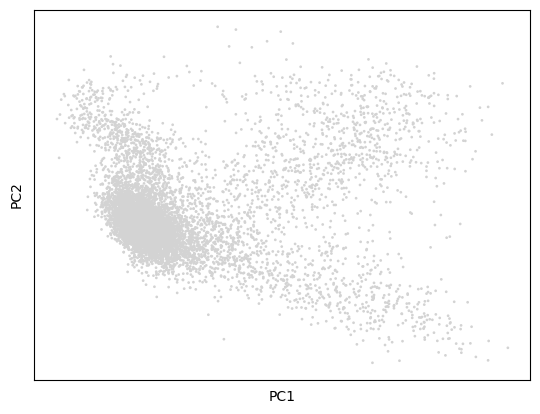

In [11]:
sc.tl.pca(adata)
sc.pl.pca(adata)

In [12]:
sc.pp.neighbors(adata)

/maps/projects/ralab/people/lpm537/software/anaconda3/envs/scenicplus_240606/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
sc.tl.umap(adata)

/maps/projects/ralab/people/lpm537/software/anaconda3/envs/scenicplus_240606/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


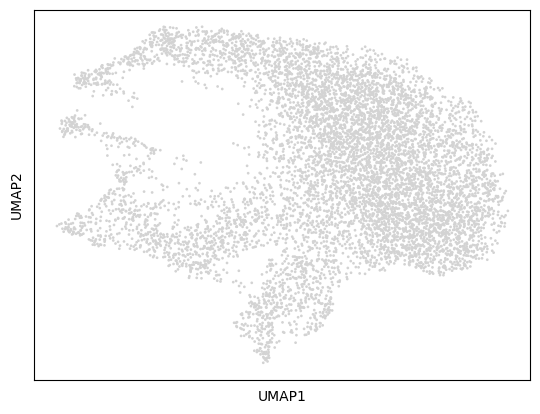

In [14]:
sc.pl.umap(adata)

In [15]:
adata.write(output_path)